Baseline SARIMA Results
RMSE: 30.142008134932393
MAE: 23.55574505723697

LSTM + Attention Results
RMSE: 82.90631478512357
MAE: 66.84845733642578


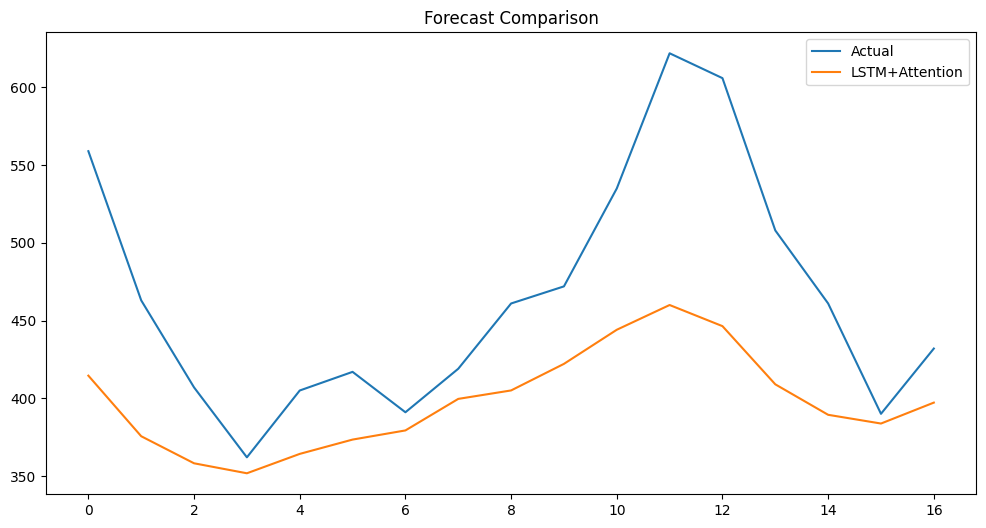

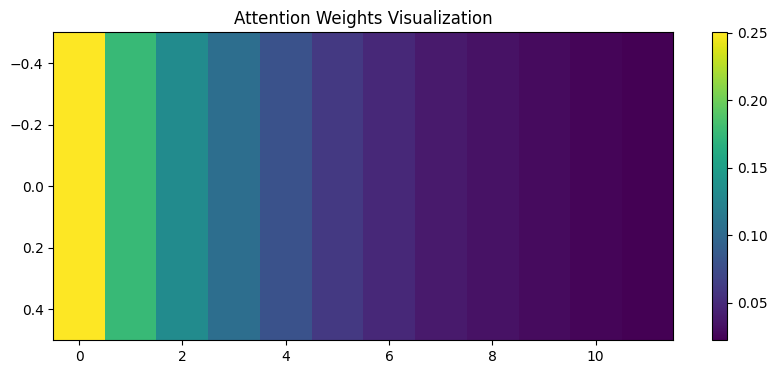


FINAL COMPARISON
SARIMA RMSE: 30.142008134932393
LSTM+Attention RMSE: 82.90631478512357
SARIMA MAE: 23.55574505723697
LSTM+Attention MAE: 66.84845733642578


In [1]:
# ==============================
# ADVANCED TIME SERIES PROJECT
# Baseline (SARIMA) vs LSTM + Attention
# ==============================

# Install if needed (Colab)
# !pip install statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# 1. LOAD DATASET
# -------------------------------
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
data = df['Passengers'].values.reshape(-1,1)

# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Train-Test Split
train_size = int(len(data_scaled)*0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# -------------------------------
# 2. CREATE SEQUENCES
# -------------------------------
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# -------------------------------
# 3. BASELINE MODEL (SARIMA)
# -------------------------------
sarima_model = SARIMAX(data[:train_size], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=len(data)-train_size)

rmse_sarima = math.sqrt(mean_squared_error(data[train_size:], sarima_forecast))
mae_sarima = mean_absolute_error(data[train_size:], sarima_forecast)

print("Baseline SARIMA Results")
print("RMSE:", rmse_sarima)
print("MAE:", mae_sarima)

# -------------------------------
# 4. LSTM + ATTENTION MODEL
# -------------------------------
class AttentionModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64):
        super(AttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        # Attention weights
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)

        out = self.fc(context)
        return out, attn_weights

model = AttentionModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# -------------------------------
# 5. TRAIN MODEL
# -------------------------------
epochs = 100

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output, _ = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

# -------------------------------
# 6. EVALUATION
# -------------------------------
model.eval()
predictions, attn_weights = model(X_test)
predictions = predictions.detach().numpy()

# Inverse transform
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.detach().numpy())

rmse_lstm = math.sqrt(mean_squared_error(y_test_inv, predictions))
mae_lstm = mean_absolute_error(y_test_inv, predictions)

print("\nLSTM + Attention Results")
print("RMSE:", rmse_lstm)
print("MAE:", mae_lstm)

# -------------------------------
# 7. PLOT RESULTS
# -------------------------------
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Actual")
plt.plot(predictions, label="LSTM+Attention")
plt.legend()
plt.title("Forecast Comparison")
plt.show()

# -------------------------------
# 8. VISUALIZE ATTENTION
# -------------------------------
plt.figure(figsize=(10,4))
plt.imshow(attn_weights[0].detach().numpy().T, aspect='auto')
plt.colorbar()
plt.title("Attention Weights Visualization")
plt.show()

# -------------------------------
# 9. FINAL COMPARISON
# -------------------------------
print("\nFINAL COMPARISON")
print("SARIMA RMSE:", rmse_sarima)
print("LSTM+Attention RMSE:", rmse_lstm)
print("SARIMA MAE:", mae_sarima)
print("LSTM+Attention MAE:", mae_lstm)
